# Time Series Analysis - Part 1

Financial price data can be represented as a time-indexed random process. It is reasonable to say that the price of oil today depends quite strongly on its price yesterday, as while real-world conditions are always changing, the condition of the world tomorrow will be very correlated to how it is today. As such, we aim to understand, model, and predict the movements in oil prices using econometric time series models.

For this notebook, we do our initial analysis of the data using time series models:

1. Plotting Autocorrelation Graphs:
We start by visualizing the sample autocorrelation of our data. We expect financial time series to be non-stationary, i.e. having time-varying mean and variance, or a unit root.

2. Testing for Stationarity: Apply tests for stationarity of the time series. We rely on the well-known Augmented Dickey Fuller (ADF) test. If stationarity shows up (which is highly likely), we will need to do differencing or observe log values (which is standard for price data).

3. Fitting Basic Models: We will look at ARIMA models, choose them based on criteria such as predictive performance (MSE) or information criteria. Then, we run tests on the residuals to see whether the models are well suited for the data.

### Imports and Initialization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, adfuller


In [2]:
COMBINED_DATA = (
    pd.read_csv("../Datasets/Futures_Oil_Combined.csv")
)

# done to ensure the Date column is parsed properly
COMBINED_DATA['Date'] = pd.to_datetime(COMBINED_DATA['Date'])

display(COMBINED_DATA)

,Date,Change_WTI,Price_WTI,Vol_WTI,Change_Brent,Price_Brent,Vol_Brent,Change_Dubai,Price_Dubai,Vol_Dubai
0,2000-01-02,0.0210,28.22,76.41K,0.0162,26.39,40.36K,NaN,NaN,NaN
1,2000-01-03,0.0440,31.77,73.33K,0.0345,29.06,42.11K,NaN,NaN,NaN
2,2000-01-05,0.0051,25.87,29.44K,NaN,NaN,NaN,NaN,NaN,NaN
3,2000-01-06,0.0390,30.14,67.23K,0.0311,29.19,28.67K,NaN,NaN,NaN
4,2000-01-08,0.0131,27.79,62.86K,0.0078,27.14,25.00K,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
6773,2024-12-06,0.0077,78.50,322.29K,0.0075,82.15,260.33K,NaN,NaN,NaN
6774,2024-12-07,-0.0050,82.21,370.06K,-0.0038,84.10,274.92K,NaN,NaN,NaN
6775,2024-12-08,0.0419,80.06,376.75K,0.0312,81.38,245.73K,NaN,NaN,NaN
6776,2024-12-09,0.0247,68.97,351.98K,0.0180,71.43,364.75K,NaN,NaN,NaN


### Autocorrelation Plot

The autocorrelation function (ACF) of a time series is the Pearson correlation between values of the data at different time lags. Intuitively, the ACF represents how similar the observations of a time series at time $t$ are with their observations at time $t-k$, i.e. its own values $k$ steps back.

Denoting the dataset as $\{{X_t}\}_{t=0}^{T}$, then the estimated autocorrelation for lag $k$ is:

\begin{equation}
    \hat{R}(k) = \frac{1}{(n - k)\sigma^2} \Sigma^{n-k}_{t=1} (X_t - \mu)(X_{t+k} - \mu)
\end{equation}

Where \mu is the sample mean, \sigma^2 the sample variance.

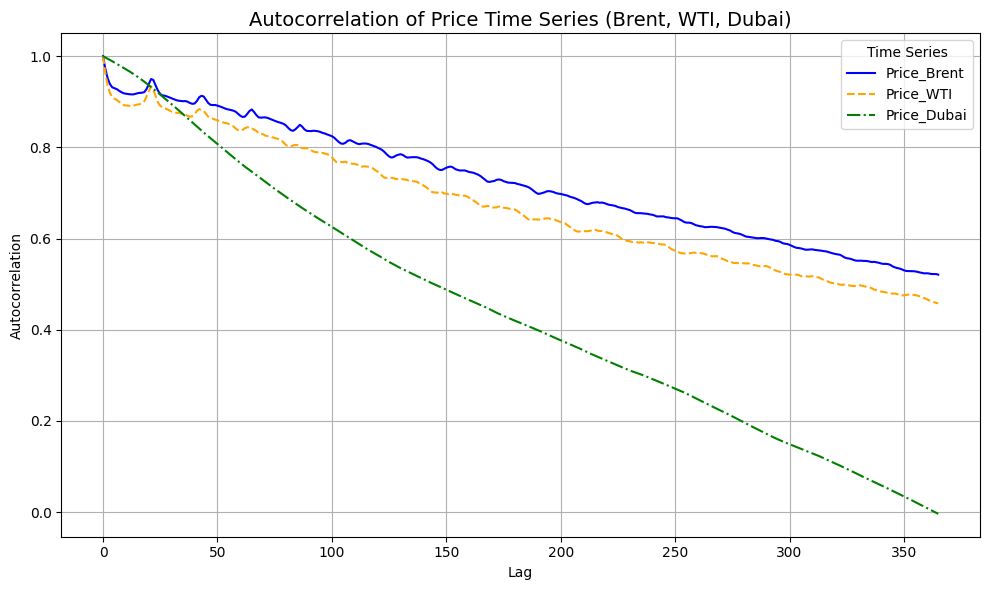

In [3]:
def plot_oil_acf(data_acf):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Colors and line styles for each time series
    colors = ['blue', 'orange', 'green']
    linestyles = ['-', '--', '-.']

    # Plot autocorrelation for each time series
    for idx, colname in enumerate(['Price_Brent', 'Price_WTI', 'Price_Dubai']):
        time_series = data_acf[colname].dropna()
        
        # Compute autocorrelations using ACF
        autocorr = acf(time_series, nlags=365)
        
        # Plot the autocorrelation with a specific color and linestyle
        ax.plot(autocorr, label=colname, color=colors[idx], linestyle=linestyles[idx])

    # Add labels and title
    ax.set_xlabel('Lag')
    ax.set_ylabel('Autocorrelation')
    ax.set_title('Autocorrelation of Price Time Series (Brent, WTI, Dubai)', fontsize=14)
    ax.legend(title='Time Series', loc='upper right')

    # Add grid for better readability
    ax.grid(True)

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()

# plot all data
data_acf_all = (
    COMBINED_DATA
    .copy()
)

plot_oil_acf(data_acf_all)



We observe similar ACF plots of the Brent and WTI oil futures, when we decide to plot the autocorrelation of each time series while keeping all the data. However, the Dubai futures plot has a completely different shape. Need to investigate this further, or decide to exclude it from the analysis.

This prompts us to have a look at the raw data again. After investigating further, we found that the data source provides us with WTI and Brent data from 01 Jan 2000, but the Dubai series only starts from 28 April 2018.

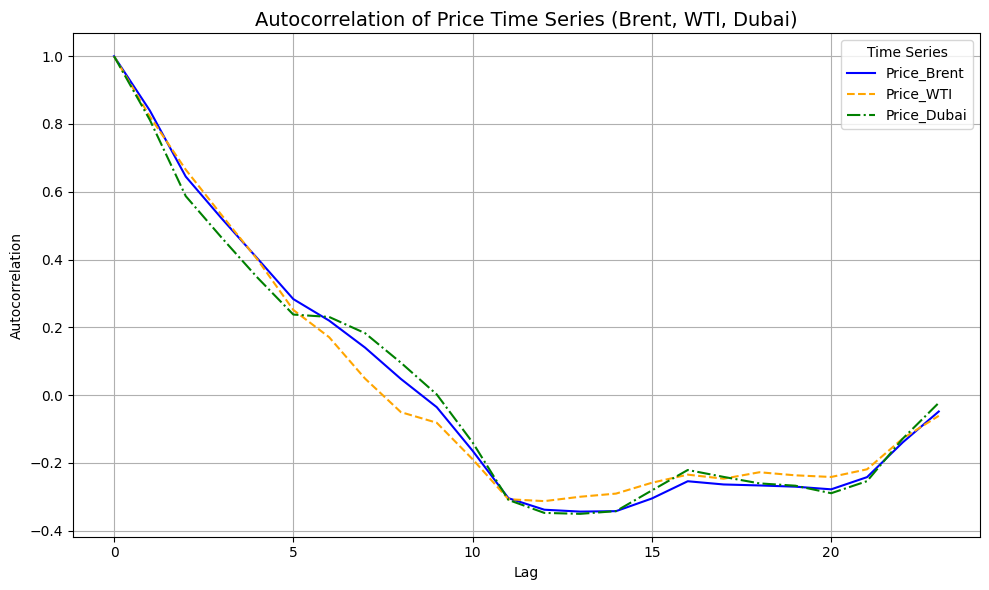

In [4]:
# before plotting all data
# drop all nan cols
data_acf = (
    COMBINED_DATA
    .copy()
    .dropna()
)

plot_oil_acf(data_acf)

If we drop all nan values before plotting, i.e. keeping only data points where all three oil futures are not nan values, we see that the autocorrelation plots are very similar for all three oil futures. This is more of what we would expect to see, as all three are used as benchmarks for 'very similar' commodities.

Interpretation of Autocorrelation Plot:
- Very high (close to 1.0) autocorrelations for lag 1, decreasing towards zero and even negative values at around lag 8.
- Indication of trends or seasonality in the data.
- The decay of the lag suggests non-stationarity in the time series (which is expected for financial price data).
- We do not see repeating peaks or cycles, so seasonality might not be the case.

### Testing for Stationarity
- Stationarity is a fundamental assumption for many time series models, including the well-known ARIMA, GARCH, and VAR. 
- If the series is not stationary, testing for autocorrelation may lead to false conclusions, as trends or seasonality can artificially inflate correlations.
- Non-stationarity: time-varying mean or variance, violating the assumptions of many statistical tools.

We will test for stationarity in the raw price data, and the returns data (even though we expect returns to be already stationarity).

### Augmented Dickey-Fuller (ADF) Test

This test is used to check for the presence of a unit root. A linear stochastic process has a unit roof, if 1 is a root of the process's characteristic equation. When such a unit root is present, the process is non-stationary, but is not neccessarily trending. If the other roots of the characteristic equation are inside the unit circle, i.e. have an absolute value less than one, then the first difference of the process will be stationary. Otherwise the process will need to be differenced multiple times to become stationary: if there are $d$ unit roots, we will need to take $d$ differences to produce a stationary series.

For the ADF test, we assume the following model for the time series $\{ y_t \}^T_{t=0}$:

\begin{equation*}
    \Delta y_t = \alpha + \beta_t + \gamma y_{t-1} + \delta_1 y_{t-1} + \cdots + \delta_{p} y_{t-p} + \epsilon_t
\end{equation*}

Where $\alpha$ is a constant or vertical axis intercept term, $\beta$ is a coefficient for the time trend, $\gamma$ is the coefficient of the lagged level of $y$, $p$ the lag order of the autoregressive process, and $\Delta$ is the single-time-step difference operator.

The test hypotheses are:

\begin{align*}
    H_0: & \: \gamma = 0 \; \text{and} \; \beta = 0
    \\
    H_1: & \: \gamma \lt 0 \; \text{and} \; \beta \neq 0
\end{align*}

i.e. under the null hypothesis of a stochastic trend, the series $y_t$ is integrated of order 1, such that the added regressors $\Delta y_t$ are all stationary. If the null hypothesis is rejected, then we have statistical evidence that the time series is stationary. 

The ADF test statistic has a non-standard distribution, as it is done over the residual term of the regression rather than the raw data.

The intuition for the test is as follows:
- If $y_t$ is stationary (or trend-stationary), then it has a tendency to return to a constant mean.
- Large values will tend to be followed by smaller values (negative changes), and vice versa. 
- Hence, the level of the series will be a significant predictor of the next period's changes, and will have a negative coefficient such that it is inversely correlated to the current change.
- On the other hand, if the series is integrated, then the positive and negative changes occur with probabilities that do not depend on the current level of the series, which is called a stochastic trend.
- The ADF test also removes all the structural effects in the time series (the autocorrelation).


Source:
Heij, Christiaan, and others, Econometric Methods with Applications in Business and Economics (Oxford, 2004; online edn, Oxford Academic, 31 Oct. 2023)

In [5]:

# Define a function to perform the ADF test
def run_adf_test(series, column_name):
    series = series.dropna()
    adf_result = adfuller(series, maxlag=100, autolag='AIC')  # Autolag selects the best lag using AIC
    print(f"Results of ADF Test for {column_name}:")
    print(f'Lag Used: {adf_result[2]}')
    print(f"ADF Statistic: {adf_result[0]}")
    print(f"p-value: {adf_result[1]}")
    print("Critical Values:")
    for key, value in adf_result[4].items():
        print(f"   {key}: {value}")
    if adf_result[1] <= 0.05:
        print(f"The null hypothesis is rejected. {column_name} is stationary.\n")
    else:
        print(f"Failed to reject the null hypothesis. {column_name} is non-stationary.\n")



In [6]:
# Apply the function to each price column
columns_to_test = ['Price_WTI', 'Price_Brent', 'Price_Dubai']

for column in columns_to_test:
    run_adf_test(COMBINED_DATA.loc[:,columns_to_test][column], column)

Results of ADF Test for Price_WTI:
Lag Used: 90
ADF Statistic: -2.6224176716880536
p-value: 0.08845193681926022
Critical Values:
   1%: -3.4313885722923336
   5%: -2.861998957482033
   10%: -2.5670143000387045
Failed to reject the null hypothesis. Price_WTI is non-stationary.

Results of ADF Test for Price_Brent:
Lag Used: 93
ADF Statistic: -2.3113871831231285
p-value: 0.1683216757711456
Critical Values:
   1%: -3.431387254397357
   5%: -2.8619983751901326
   10%: -2.567013990071056
Failed to reject the null hypothesis. Price_Brent is non-stationary.

Results of ADF Test for Price_Dubai:
Lag Used: 0
ADF Statistic: -2.1653251285082478
p-value: 0.21907019230407393
Critical Values:
   1%: -3.432807985211508
   5%: -2.8626259540301553
   10%: -2.5673480904338657
Failed to reject the null hypothesis. Price_Dubai is non-stationary.



The ADF test shows non-stationarity for all three oil futures. However, the Dubai oil futures again show irregularity, with a value of zero for 'Lag Used'. We will try the test again, but after dropping all rows with nan values.

In [7]:
# Apply the function to each price column
columns_to_test = ['Price_WTI', 'Price_Brent', 'Price_Dubai']

for column in columns_to_test:
    run_adf_test(COMBINED_DATA.loc[:,columns_to_test].dropna()[column], column)

Results of ADF Test for Price_WTI:
Lag Used: 22
ADF Statistic: -2.3635933402976654
p-value: 0.15227660213237626
Critical Values:
   1%: -3.4331548442701627
   5%: -2.8627791265652154
   10%: -2.56742964160809
Failed to reject the null hypothesis. Price_WTI is non-stationary.

Results of ADF Test for Price_Brent:
Lag Used: 22
ADF Statistic: -2.3955605211874214
p-value: 0.142993341359838
Critical Values:
   1%: -3.4331548442701627
   5%: -2.8627791265652154
   10%: -2.56742964160809
Failed to reject the null hypothesis. Price_Brent is non-stationary.

Results of ADF Test for Price_Dubai:
Lag Used: 20
ADF Statistic: -2.675750865713187
p-value: 0.07832924395612358
Critical Values:
   1%: -3.4331524402158027
   5%: -2.862778064998932
   10%: -2.567429076405341
Failed to reject the null hypothesis. Price_Dubai is non-stationary.



Now, the three time series show similar lag values used for the ADF test. We note that we have found another irregularity with the Dubai time series, and we must decide whether to proceed with two options:

1. Remove all pre-2014 data, and run the analysis on all three oil futures
2. Remove the Dubai series and work only with the WTI and Brent futures
3. Try to find more data for the Dubai series, pre-2014 (we are unsure whether this even exists)

We decide to choose the first option, such that we may also used error correction models to observe cointegration relations between the three oil futures.